In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from ringer.utils import significant_around, get_number_order
from ringer.data import load_var_infos
from ringer.latex import confidence_region_df_as_latex
DATASET_TYPES = ["train", "test"]

In [2]:
ratios = {
    # 'ratio1': lambda x: x['boosted_el']/x['boosted_jet'],
    'ratio1': lambda x: x['boosted_el']/x['el_jet'],
    'ratio2': lambda x: (x['boosted_jet']-x['boosted_el'])/x['el_jet'],
    'ratio3': lambda x: x['boosted_jet']-x['boosted_el']
}
ratios_labels = {
'ratio1': '$rd_1$',
# 'ratio1_extra': '$rd_1\'$',
'ratio2': '$rd_2$',
'ratio3': '$rd_3$'
}
n_folds = 10
var_infos = load_var_infos()
var_infos

,name,label,type,formula,description
col,,,,,
trig_L2_cl_et,et,$E_T$,var,NaN,Transverse particle energy on the calorimeter ...
el_et,et,$E_T$,var,NaN,Transverse particle energy on the calorimeter ...
trig_L2_cl_eta,eta,$\eta$,var,NaN,Pseudorapidity (L2Calo stage)
el_eta,eta,$\eta$,var,NaN,Pseudorapidity (Offline stage)
trig_L2_cl_reta,reta,$R_{\eta}$,shower_shape,$R_{\eta} = \frac{E^{3x7}_{EM2}}{E^{7x7}_{EM2}}$,Ratio of the energy in 3x7 cells over the ener...
trig_L2_cl_eratio,eratio,$E_{ratio}$,shower_shape,$E_{ratio} = \frac{E^{max}_{EM1} - E^{2^{nd}ma...,Ratio of the energy difference between the max...
trig_L2_cl_f1,f1,$f_1$,shower_shape,$f_1 = \frac{E^{total}_{EM1}}{E^{total}_{EM}}$,Ratio of the energy in the first layer to the ...
trig_L2_cl_ehad1,ehad1,$E_{had1}$,unidentified,NaN,Unidentified (L2Calo Stage)
trig_L2_cl_f3,f3,$f_3$,shower_shape,$f_3 = \frac{E^{total}_{EM3}}{E^{total}_{EM}}$,Ratio of the energy in the third layer to the ...


In [3]:
wass_distances = pd.read_csv(os.path.join('..', '..', 'data', 'wass_distances.csv'), index_col=0)
for name, func in ratios.items():
    wass_distances[name] = wass_distances.apply(func, axis=1)
wass_distances = wass_distances.set_index('index')
wass_distances.index.name = "col"
wass_distances.head(10)

,boosted_el,boosted_jet,el_jet,description,ratio1,ratio2,ratio3
col,,,,,,,
trig_L2_cl_reta,0.003692,0.034417,0.031252,fold_0_train,0.118144,0.983138,0.030725
trig_L2_cl_reta,0.003664,0.034350,0.031288,fold_0_test,0.117108,0.980774,0.030686
trig_L2_cl_reta,0.003693,0.034409,0.031257,fold_1_train,0.118137,0.982702,0.030717
trig_L2_cl_reta,0.003683,0.034420,0.031238,fold_1_test,0.117900,0.983982,0.030737
trig_L2_cl_reta,0.003697,0.034414,0.031256,fold_2_train,0.118288,0.982731,0.030716
trig_L2_cl_reta,0.003643,0.034379,0.031249,fold_2_test,0.116577,0.983604,0.030736
trig_L2_cl_reta,0.007819,0.073079,0.066388,fold_3_train,0.117782,0.982998,0.065259
trig_L2_cl_reta,0.007992,0.073187,0.066392,fold_3_test,0.120376,0.981972,0.065195
trig_L2_cl_reta,0.003688,0.034408,0.031256,fold_4_train,0.117989,0.982864,0.030720


In [4]:
def get_dataset_descriptions(wass_distances: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    dataset_regex = f"fold_[0-9]+_{dataset_type}"
    is_dataset = wass_distances['description'].str.contains(dataset_regex)
    selected_columns = wass_distances.columns[wass_distances.columns != 'description']
    dataset_folds = wass_distances.loc[is_dataset, selected_columns]   #type: ignore
    described_dataset = dataset_folds.groupby('col').agg(['mean', 'std', "min", "max"])
    described_dataset = described_dataset.sort_values(by=('boosted_el', 'mean'))
    cols2melt = described_dataset.columns.to_list()
    described_dataset = described_dataset.reset_index()
    described_dataset = described_dataset.melt(id_vars=[("col", "")],
                                                       value_vars=cols2melt,
                                                       var_name=["metric", "agg_metric"])
    described_dataset["dataset_type"] = dataset_type
    described_dataset = described_dataset.rename({("col",""): "var"}, axis=1)
    return described_dataset

described_types = [
    get_dataset_descriptions(wass_distances, dataset_type)
    for dataset_type in DATASET_TYPES
]
description_df = pd.concat(described_types, axis=0)
description_df["metric"] = description_df["metric"].astype("category")
description_df["agg_metric"] = description_df["agg_metric"].astype("category")
description_df["dataset_type"] = description_df["dataset_type"].astype("category")
description_df["var"] = description_df["var"].astype("category")
description_df.dtypes 

var             category
metric          category
agg_metric      category
value            float64
dataset_type    category
dtype: object

Plotting boosted_el train
Plotting boosted_el sub ax train
Plotting boosted_el test
Plotting boosted_el sub ax test
Plotting boosted_jet train
Plotting boosted_jet test
Plotting el_jet train
Plotting el_jet test


/tmp/ipykernel_260728/2879027721.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Plotting ratio1 train
Plotting ratio1 sub ax train
Plotting ratio1 test
Plotting ratio1 sub ax test
Plotting ratio2 train
Plotting ratio2 sub ax train
Plotting ratio2 test
Plotting ratio2 sub ax test
Plotting ratio3 train
Plotting ratio3 test


/tmp/ipykernel_260728/2879027721.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_260728/2879027721.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


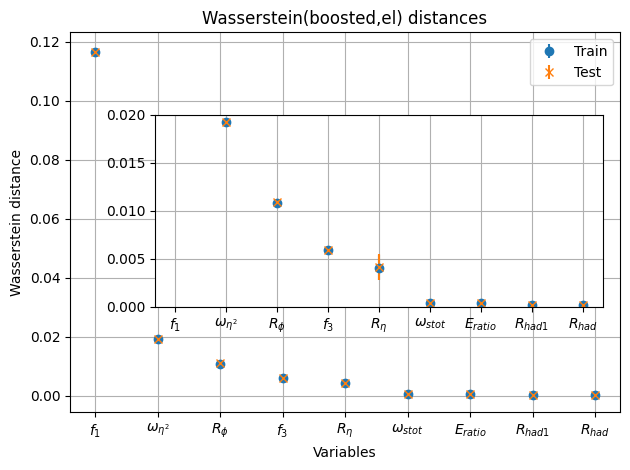

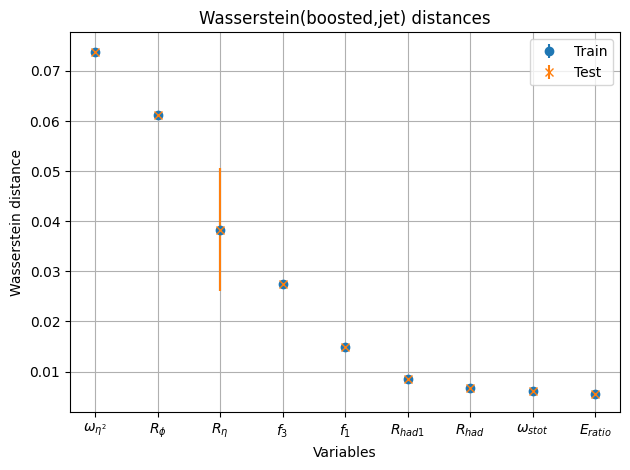

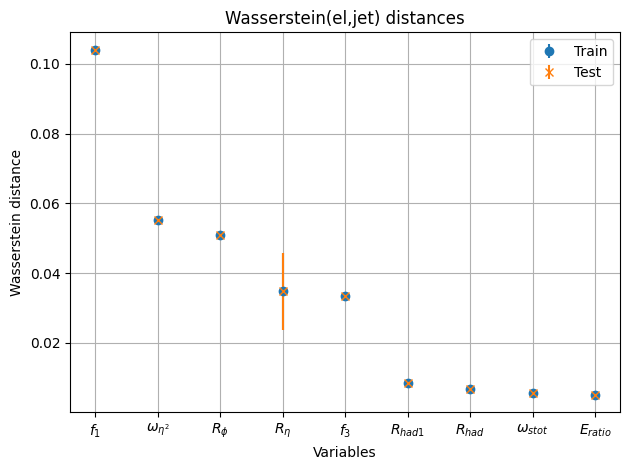

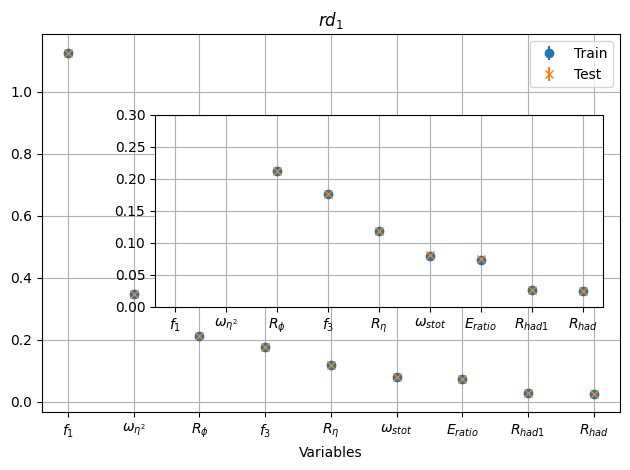

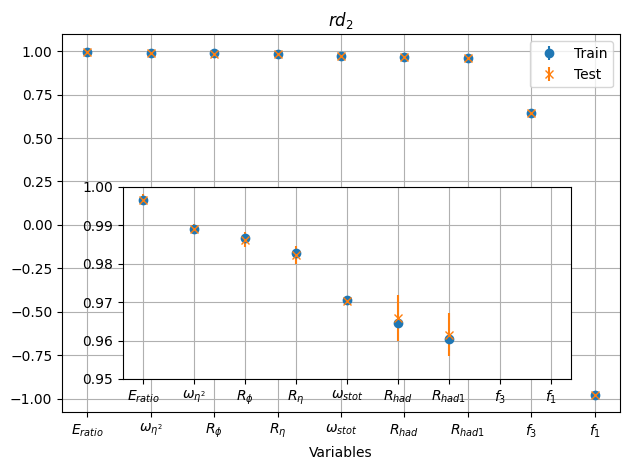

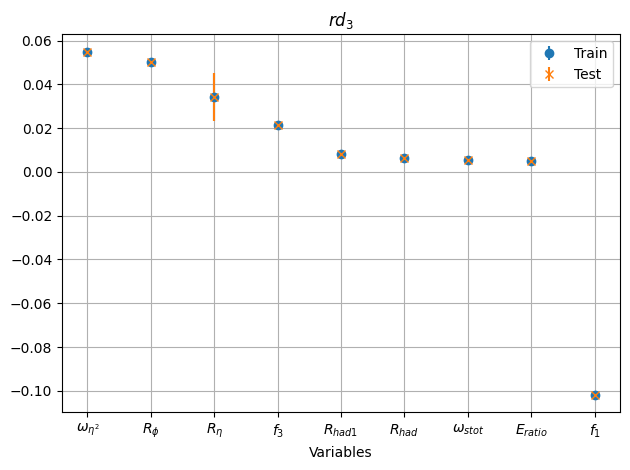

In [8]:
sub_ax_kwargs = defaultdict(lambda: None)
sub_ax_kwargs["boosted_el"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.02))
sub_ax_kwargs["ratio1_extra"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.4))
sub_ax_kwargs["ratio1"] = dict(pos=[0.25, 0.35, 0.7, 0.4], ylim=(0,0.3))
sub_ax_kwargs["ratio2"] = dict(pos=[0.2, 0.2, 0.7, 0.4], ylim=(0.95,1))
plots = dict()
for metric in description_df["metric"].unique():
    is_distance = not metric.startswith("ratio")
    plots[metric] = plt.subplots()
    fig, ax = plots[metric]
    ax.grid()
    if sub_ax_kwargs[metric]:
        sub_ax = fig.add_axes(sub_ax_kwargs[metric]["pos"])
        sub_ax.grid()
    for i , dataset_type in enumerate(DATASET_TYPES):
        print(f"Plotting {metric} {dataset_type}")
        
        dataset_regex = f"fold_[0-9]+_{dataset_type}"
        is_test = dataset_type == "test"
        marker = "x" if is_test else "o"
        color = f"C{i}"
        label = dataset_type.capitalize()
        xlabel = "Variables"
        
        if is_distance:
            metric_label = metric.replace("_", ",")
            title = f"Wasserstein({metric_label}) distances"
            ylabel = "Wasserstein distance"
        else:
            title = ratios_labels[metric]
            ylabel = None
        
        is_test = dataset_type == "test"
        is_type = description_df["dataset_type"] == dataset_type
        # is_metric = description_df["metric"] == metric
        is_mean = description_df["agg_metric"] == "mean"
        is_std = description_df["agg_metric"] == "std"
        valid_sample = is_type # & is_metric
        plot_df = description_df.loc[valid_sample & (is_mean | is_std)]
        plot_df = plot_df.pivot(index="var",
                                values="value",
                                columns=["metric", "agg_metric"])
        plot_df = plot_df.rename(var_infos["label"], axis=0)
        plot_df = plot_df.sort_values(by=(metric, "mean"), ascending=False)
        ax.errorbar(plot_df.index, plot_df[(metric, "mean")],
                    yerr=plot_df[(metric, "std")],
                    fmt=marker, color=color,
                    label=label)        
        ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
        
        if sub_ax_kwargs[metric]:
            print(f"Plotting {metric} sub ax {dataset_type}")
            sub_ax.errorbar(plot_df.index, plot_df[(metric, "mean")],
                            yerr=plot_df[(metric, "std")],
                            fmt=marker, color=color)
            sub_ax.set(ylim=sub_ax_kwargs[metric]["ylim"])
    ax.legend()
    fig.tight_layout()

In [6]:
wass_distance_columns = ['boosted_el', 'boosted_jet', 'el_jet']
train_data = train_folds[wass_distance_columns].rename(col2label_mapping, axis=0)
train_data.index.name = 'Shower Shape Variable'
latex_repr = confidence_region_df_as_latex(train_data,
                                           groupby='Shower Shape Variable',
                                           sort_values=dict(by='boosted_el', ascending=True))
print(latex_repr)

\begin{tabular}{||c|c|c|c|c||}
 & Shower Shape Variable & boosted_el & boosted_jet & el_jet \\
0 & $R_{had}$ & $0.00017 \pm 0.00002$ & $0.0066 \pm 0.0009$ & $0.0067 \pm 0.0009$ \\
\cline{1-5}
1 & $R_{had1}$ & $0.00023 \pm 0.00001$ & $0.0085 \pm 0.0004$ & $0.0086 \pm 0.0004$ \\
\cline{1-5}
2 & $E_{ratio}$ & $0.000383 \pm 0.000001$ & $0.005540 \pm 0.000003$ & $0.005175 \pm 0.000002$ \\
\cline{1-5}
3 & $\omega_{stot}$ & $0.00046 \pm 0.00006$ & $0.0061 \pm 0.0008$ & $0.0058 \pm 0.0007$ \\
\cline{1-5}
4 & $R_{\eta}$ & $0.004 \pm 0.001$ & $0.04 \pm 0.01$ & $0.03 \pm 0.01$ \\
\cline{1-5}
5 & $f_3$ & $0.00593 \pm 0.00007$ & $0.0275 \pm 0.0004$ & $0.0334 \pm 0.0004$ \\
\cline{1-5}
6 & $R_{\phi}$ & $0.010848 \pm 0.000008$ & $0.06123 \pm 0.00001$ & $0.051055 \pm 0.000006$ \\
\cline{1-5}
7 & $\omega_{\eta^2}$ & $0.0192 \pm 0.0001$ & $0.0738 \pm 0.0004$ & $0.0552 \pm 0.0003$ \\
\cline{1-5}
8 & $f_1$ & $0.1167 \pm 0.0001$ & $0.01488 \pm 0.00007$ & $0.1039 \pm 0.0001$ \\
\cline{1-5}
\end{tabular}



In [7]:
wass_distance_columns = ['boosted_el', 'boosted_jet', 'el_jet']
train_data = train_folds[list(ratios.keys())] \
    .rename(col2label_mapping, axis=0) \
    .rename(ratios_labels, axis=1)
train_data.index.name = 'Shower Shape Variable'
latex_repr = confidence_region_df_as_latex(train_data,
                                           groupby='Shower Shape Variable',
                                           sort_values=dict(by='$rd_1\'$', ascending=True))
print(latex_repr)

\begin{tabular}{||c|c|c|c|c|c||}
 & Shower Shape Variable & $rd_1$ & $rd_1'$ & $rd_2$ & $rd_3$ \\
0 & $R_{had}$ & $0.0257 \pm 0.0005$ & $0.0255 \pm 0.0005$ & $0.9646 \pm 0.0007$ & $0.0065 \pm 0.0009$ \\
\cline{1-6}
1 & $R_{had1}$ & $0.0275 \pm 0.0004$ & $0.0271 \pm 0.0004$ & $0.9604 \pm 0.0006$ & $0.0083 \pm 0.0004$ \\
\cline{1-6}
2 & $E_{ratio}$ & $0.0691 \pm 0.0002$ & $0.0740 \pm 0.0002$ & $0.9965 \pm 0.0001$ & $0.005157 \pm 0.000002$ \\
\cline{1-6}
3 & $\omega_{stot}$ & $0.0764 \pm 0.0001$ & $0.0803 \pm 0.0001$ & $0.9705 \pm 0.0001$ & $0.0056 \pm 0.0007$ \\
\cline{1-6}
4 & $R_{\eta}$ & $0.1072 \pm 0.0001$ & $0.1180 \pm 0.0002$ & $0.9829 \pm 0.0003$ & $0.03 \pm 0.01$ \\
\cline{1-6}
5 & $f_3$ & $0.2153 \pm 0.0006$ & $0.1773 \pm 0.0004$ & $0.6462 \pm 0.0008$ & $0.0216 \pm 0.0003$ \\
\cline{1-6}
6 & $R_{\phi}$ & $0.1772 \pm 0.0001$ & $0.2125 \pm 0.0002$ & $0.9867 \pm 0.0002$ & $0.05038 \pm 0.00001$ \\
\cline{1-6}
7 & $\omega_{\eta^2}$ & $0.2605 \pm 0.0002$ & $0.3485 \pm 0.0004$ & $0.989

In [9]:
def get_order(df: pd.DataFrame, sort_col: str) -> pd.Series:
    ascending = sort_col.startswith('ratio1')
    df = df.sort_values(sort_col, ascending=ascending)
    ordered_ss = df['name'].values
    values = df[sort_col].values
    row = pd.Series(
        [ordered_ss, values],
        index=['order', 'values']
    )
    return row
orders = {
    name: wass_distances.reset_index().groupby('description').apply(get_order, sort_col=name) # type: ignore
    for name in ratios.keys()
}
orders['ratio1']

,order,values
description,,
fold_0_test,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.021755286020114534, 0.0245273857710684, 0.0..."
fold_0_train,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.02619237717321508, 0.027811661018235914, 0...."
fold_1_test,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.025484859038670225, 0.028842585397723414, 0..."
fold_1_train,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.025773351971415722, 0.0273338915631281, 0.0..."
fold_2_test,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.02686263125629836, 0.028692019053359524, 0...."
fold_2_train,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.025623016811357455, 0.027348358395745596, 0..."
fold_3_test,"[el_rhad1, el_rhad, trig_L2_cl_eratio, trig_L2...","[0.025982262076547424, 0.028678803011021776, 0..."
fold_3_train,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.025416277863176268, 0.02765187043182015, 0...."
fold_4_test,"[el_rhad, el_rhad1, trig_L2_cl_eratio, trig_L2...","[0.02387374661563861, 0.02666601396825327, 0.0..."


In [10]:
def get_order_differences(df: pd.DataFrame, n_folds: int):
    differences = list()
    for ifold in range(n_folds):
        train_fold_order = df.loc[f'fold_{ifold}_train', 'order']
        test_fold_order = df.loc[f'fold_{ifold}_test', 'order']
        is_different = (train_fold_order !=
                        test_fold_order).any()   # type: ignore
        if is_different:
            differences.append(f'fold_{ifold}')
    return differences

order_differences = {
    ratio_name: get_order_differences(ratio_order, n_folds)
    for ratio_name, ratio_order in orders.items()
}
order_differences

{'ratio1': ['fold_3', 'fold_5'],
 'ratio1_extra': ['fold_3', 'fold_5'],
 'ratio2': ['fold_0', 'fold_5', 'fold_6', 'fold_7', 'fold_8'],
 'ratio3': []}

In [11]:
def side_by_side_vis(orders, ratio, fold):
    df = orders[ratio]
    is_fold = df.index.str.startswith(fold)
    for col in ['order', 'values']:
        for idx, item in df.loc[is_fold, col].items():
            print(f'{idx}: {item}')

side_by_side_vis(orders, 'ratio1', 'fold_3')

fold_3_test: ['el_rhad1' 'el_rhad' 'trig_L2_cl_eratio' 'trig_L2_cl_wstot'
 'trig_L2_cl_reta' 'el_rphi' 'trig_L2_cl_f3' 'trig_L2_cl_weta2'
 'trig_L2_cl_f1']
fold_3_train: ['el_rhad' 'el_rhad1' 'trig_L2_cl_eratio' 'trig_L2_cl_wstot'
 'trig_L2_cl_reta' 'el_rphi' 'trig_L2_cl_f3' 'trig_L2_cl_weta2'
 'trig_L2_cl_f1']
fold_3_test: [0.02598226 0.0286788  0.07120017 0.07617795 0.10920005 0.17695708
 0.20916133 0.26172887 8.16610006]
fold_3_train: [0.02541628 0.02765187 0.06892658 0.07645413 0.10699891 0.17726448
 0.21594283 0.26041652 7.80572275]


In [ ]:
side_by_side_vis(orders, 'ratio1_extra', 'fold_4')

In [ ]:
side_by_side_vis(orders, 'ratio2', 'fold_0')

In [ ]:
side_by_side_vis(orders, 'ratio3', 'fold_0')